In [104]:
import pandas as pd
import yfinance as yf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

import warnings
warnings.filterwarnings("ignore")

In [105]:
uk_tickers = pd.read_html('https://en.wikipedia.org/wiki/FTSE_100_Index#Constituents',header=0)
uk_tickers = uk_tickers[4]['Ticker'] + '.L'
uk_tickers

0      III.L
1     ABDN.L
2      ADM.L
3      AAF.L
4      AAL.L
       ...  
95     UTG.L
96     VOD.L
97    WEIR.L
98     WTB.L
99     WPP.L
Name: Ticker, Length: 100, dtype: object

In [106]:
data = yf.download(list(uk_tickers), start='2021-01-01')

[*********************100%***********************]  100 of 100 completed


In [107]:
data = data['Adj Close']

In [108]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(data.isnull().sum().sum())
    print(data.isnull().sum()[data.isnull().sum() > 0])

449
AAF.L       1
AAL.L       1
BARC.L      1
BATS.L      1
BP.L        7
CPG.L       1
CRDA.L      1
CRH.L       2
DCC.L       1
EXPN.L      1
GLEN.L      6
GSK.L       1
HLN.L     387
IAG.L       5
IHG.L       1
ITRK.L      1
JMAT.L      5
LLOY.L      2
OCDO.L      1
PSH.L       2
RIO.L       1
RS1.L      10
RTO.L       1
SGE.L       1
SGRO.L      1
SHEL.L      1
TSCO.L      1
TW.L        1
VOD.L       1
WEIR.L      1
WPP.L       1
WTB.L       1
dtype: int64


In [109]:
data.fillna(method='ffill', inplace=True)

In [110]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(data.isnull().sum().sum())
    print(data.isnull().sum()[data.isnull().sum() > 0])

387
HLN.L    387
dtype: int64


In [111]:
data.index = pd.to_datetime(data.index)

In [112]:
data_pc_change = data.pct_change()

In [113]:
df_pc_change = data_pc_change[:'2021-12-31']
df_pc_change = df_pc_change.std()*(252**0.5)*100
df_pc_change = df_pc_change.sort_values(ascending=False)
df_pc_change

EDV.L     57.231041
IAG.L     50.349834
RR.L      44.681992
AAL.L     40.311557
ANTO.L    36.749485
            ...    
REL.L     16.436232
DGE.L     16.204924
NG.L      15.601019
FCIT.L    15.218175
HLN.L           NaN
Length: 100, dtype: float64

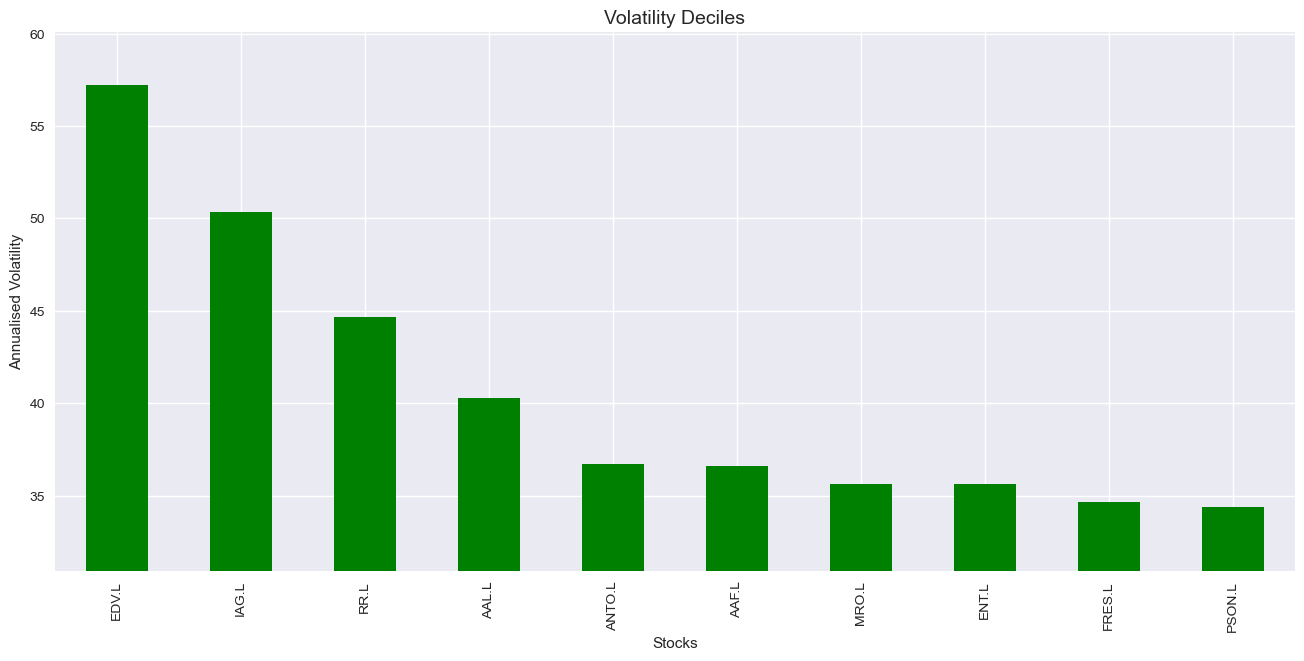

In [114]:
top_vol_decile = df_pc_change[:int(len(df_pc_change)*0.1)]
top_vol_decile.plot.bar(figsize=(16,7), color='green',ylim=top_vol_decile.min()*0.9)
plt.title('Volatility Deciles', fontsize=14)
plt.xlabel('Stocks')
plt.ylabel('Annualised Volatility')
plt.show()

In [116]:
data['ANTO.L']['2022-06'] = 1348.3252 # Fixing data supply error

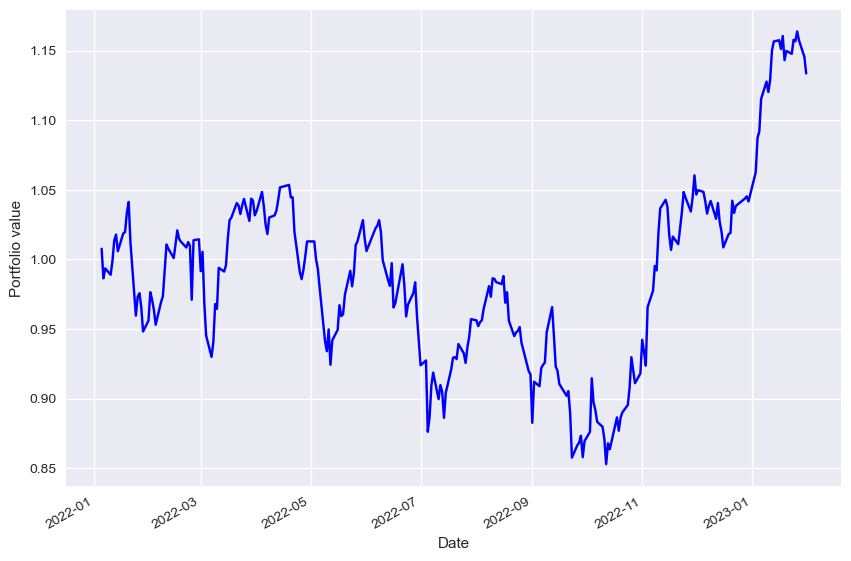

In [117]:
stock_data = data.loc['2022-1':'2023-1',top_vol_decile.index]
stock_data_pc = stock_data.pct_change()
portfolio = pd.DataFrame()
portfolio['returns'] = stock_data_pc.mean(axis=1)
portfolio['value'] = (portfolio+1).cumprod()
portfolio.value.plot(color='b',figsize=(10,7))
plt.ylabel("Portfolio value")
plt.show()


DatetimeIndex(['2022-01-04', '2022-01-05', '2022-01-06', '2022-01-07',
               '2022-01-10', '2022-01-11', '2022-01-12', '2022-01-13',
               '2022-01-14', '2022-01-17',
               ...
               '2023-01-18', '2023-01-19', '2023-01-20', '2023-01-23',
               '2023-01-24', '2023-01-25', '2023-01-26', '2023-01-27',
               '2023-01-30', '2023-01-31'],
              dtype='datetime64[ns]', name='Date', length=271, freq=None)


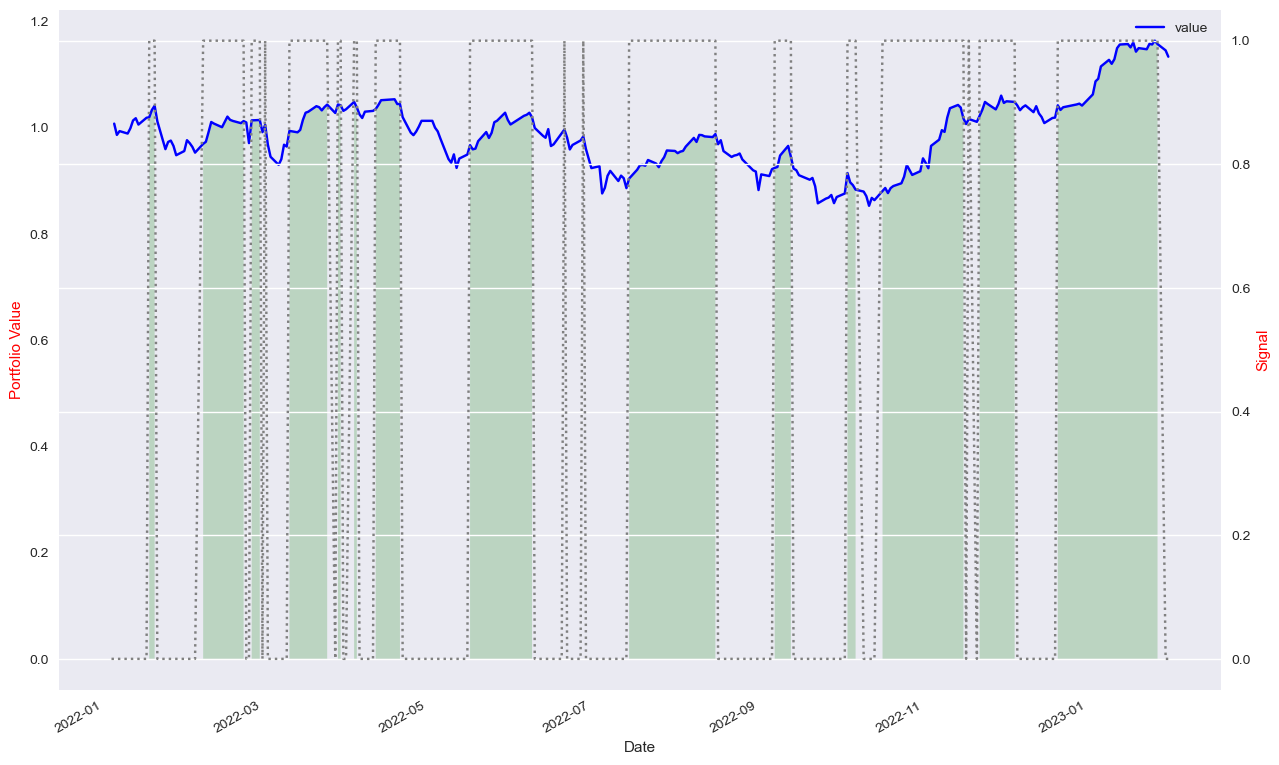

In [118]:
def get_strategy_returns_sma(portfolio):
    portfolio['sma10'] = portfolio.value.rolling(window=10).mean()
    portfolio['signal'] = np.where(portfolio.value > portfolio.sma10,1,0)
    
    portfolio['str_returns'] = portfolio['returns'].shift(-1) * portfolio['signal']
    
    return portfolio

def plot_signal(portfolio):
    portfolio['value'].plot(color='blue')    
    plt.fill_between(portfolio.index, portfolio.value, where=(portfolio.signal==1), facecolor='g', alpha=0.2)
    print(portfolio.index)
    plt.legend()
    plt.ylabel('Portfolio Value',color='r')
    # Plot the signal values    
    portfolio['signal'].plot(secondary_y=True,figsize=(15,10),color='grey', linestyle='dotted')
    plt.ylabel('Signal',color='r')
    plt.show()

portfolio = get_strategy_returns_sma(portfolio)    
plot_signal(portfolio)  

The Sharpe ratio is 1.46 


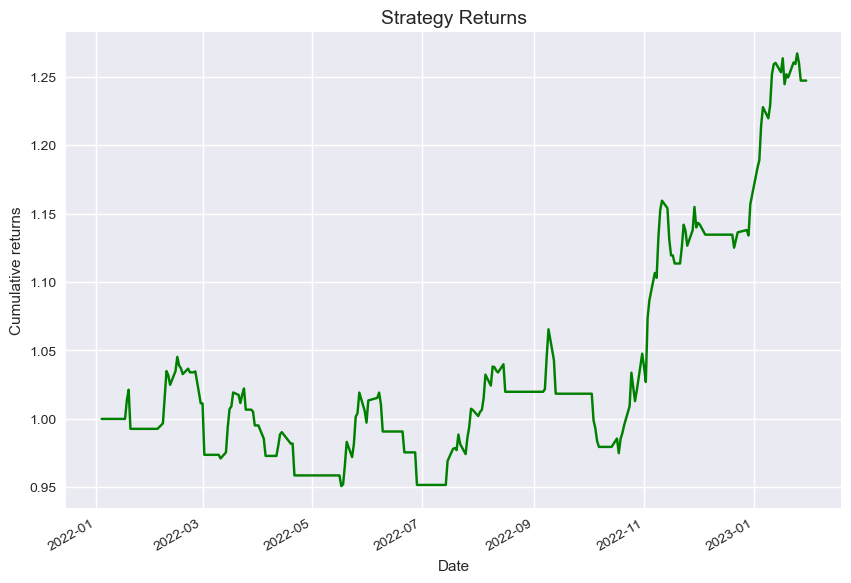

The maximum drawdown is -9.03


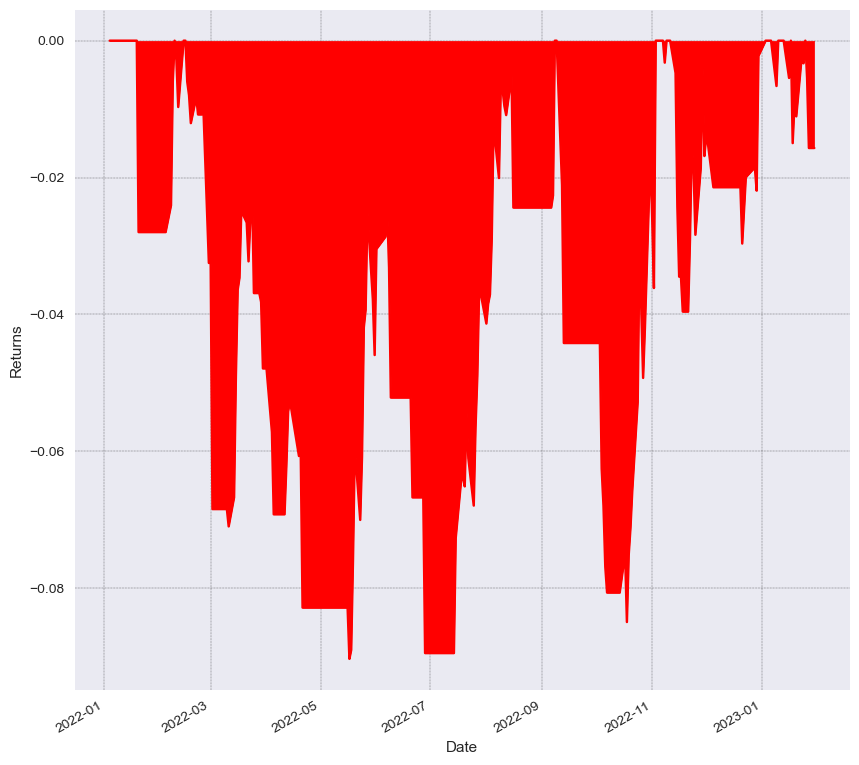

In [119]:
def plot_returns_dd(portfolio):
    # ----------- Sharpe ratio ------------------
    sharpe_ratio = np.mean(portfolio.str_returns)/np.std(portfolio.str_returns)*(252**0.5)
    print('The Sharpe ratio is %.2f ' % sharpe_ratio)

    # ----------- Cumulative strategy returns ------------------
    portfolio['cum_str_returns'] = (portfolio['str_returns']+1).cumprod()
    # Plot the cumulative strategy returns
    portfolio['cum_str_returns'].plot(figsize=(10,7), color='green')
    plt.title('Strategy Returns', fontsize=14)
    plt.ylabel('Cumulative returns')
    plt.show()        

    # ----------- Drawdown ------------------    
    # Calculate the running maximum
    running_max = np.maximum.accumulate(portfolio['cum_str_returns'].dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = (portfolio['cum_str_returns'])/running_max - 1
    max_dd = drawdown.min()*100
    print('The maximum drawdown is %.2f' % max_dd)
    # Plot the drawdowns
    drawdown.plot(color='r',figsize=(10,10))
    plt.ylabel('Returns')
    plt.fill_between(drawdown.index, drawdown, color='red')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()    
    
plot_returns_dd(portfolio)